In [22]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.model_selection import train_test_split
import sagemaker
import boto3
import io 
import sagemaker.amazon.common as smac 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

In [23]:
insurance = pd.read_csv('insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [24]:
ins = pd.get_dummies(data = insurance, drop_first = True )


In [25]:
ins.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_new = scaler.fit_transform(ins.drop(columns = ['charges']))

In [27]:
pd.DataFrame(X_new).shape

(1338, 8)

In [28]:
y=ins['charges']


In [29]:
X = np.array(X_new).astype('float32')
y = np.array(y).astype('float32')

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
X_train.shape

(1070, 8)

In [32]:
X_train[0]

array([-0.3707464 , -1.9133159 ,  1.5809257 , -1.0105187 , -0.5074631 ,
       -0.5664179 , -0.61132365, -0.5664179 ], dtype=float32)

In [33]:
#Create a SageMaker session

sagemaker_session = sagemaker.Session()
bucket = "ml-sagemaker-gwu"

#Access SageMaker role created prior to session
#Need to pass role to training job
role = sagemaker.get_execution_role()
print(role)


arn:aws:iam::051677741640:role/service-role/AmazonSageMaker-ExecutionRole-20211229T211710


In [34]:
#Need to convert dataset to RecordIO format for Linear Learner to understand


buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0) 

###Uploading training data
#Filename for training data we are uploading to S3 
key = 'linear-train-data'
prefix = 'medical_data'
#Upload training data to S3
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

###Uploading test data
buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0)

#Sub-folder for test data
key = 'linear-test-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

###Model Artifacts
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

uploaded training data location: s3://ml-sagemaker-gwu/medical_data/train/linear-train-data
uploaded training data location: s3://ml-sagemaker-gwu/medical_data/test/linear-test-data
Training artifacts will be uploaded to: s3://ml-sagemaker-gwu/medical_data/output


In [35]:
from sagemaker.amazon.amazon_estimator import image_uris
container = image_uris.retrieve('linear-learner', boto3.Session().region_name)

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

In [36]:
linear.set_hyperparameters(feature_dim = 8,
                           predictor_type = 'regressor',
                           mini_batch_size = 20,
                           epochs = 5,
                           num_models = 10,
                           loss = 'absolute_loss')

In [37]:
linear.fit({'train': s3_train_data})


2022-01-03 00:38:56 Starting - Starting the training job...
2022-01-03 00:38:58 Starting - Launching requested ML instancesProfilerReport-1641170336: InProgress
...
2022-01-03 00:39:53 Starting - Preparing the instances for training.........
2022-01-03 00:41:21 Downloading - Downloading input data...
2022-01-03 00:41:53 Training - Downloading the training image...
2022-01-03 00:42:25 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[01/03/2022 00:42:19 INFO 139680974665536] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale

In [38]:
linear_regressor = linear.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

#need to make sure data is in correct format for deployed model
from sagemaker.predictor import csv_serializer, json_deserializer
linear_regressor.serializer = csv_serializer
linear_regressor.deserializer = json_deserializer

-------!

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


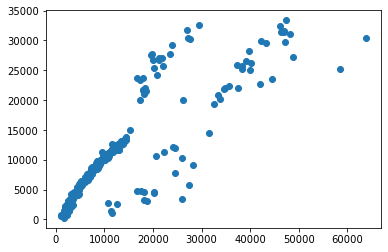

In [39]:
result = linear_regressor.predict(X_test)
result #should be a JSON

#Iterate the result JSON to get an NP array of all the predictions so we can compare to Y test
predictions = np.array([res['score'] for res in result['predictions']])
predictions #should now be an numpy array

#Visualize how accurate predictions are relative to y_test
plt.scatter(y_test, predictions)

In [40]:
from sklearn import metrics 
np.sqrt(metrics.mean_squared_error(y_test, predictions))

7023.8777555925935

In [41]:
#sagemaker.Session().delete_endpoint(linear_regressor.endpoint)